In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

# 1. Load Data
bracket_train = pd.read_csv("bracket_training_cleaned.csv")
institutions = pd.read_csv("CCAC 2025 - Institutions_cleaned.csv")

# 2. Extract Other Data form Institutions Data
inst_scale = institutions[[
    "InstitutionID", 
    "InstitutionEnrollment_Male", 
    "InstitutionEnrollment_Female", 
    "InstitutionEnrollment_Total"
]].copy()

# 3. Merge Other Data into 'bracket_train'
regions = ["East", "West", "South", "Midwest"]
for region in regions:
    region_col = f"RegionWinner_{region}"
    inst_temp = inst_scale.copy()
    inst_temp.rename(columns={
    "InstitutionID": region_col,
    "InstitutionEnrollment_Male": f"{region}_InstitutionEnrollment_Male",
    "InstitutionEnrollment_Female": f"{region}_InstitutionEnrollment_Female",
    "InstitutionEnrollment_Total": f"{region}_InstitutionEnrollment_Total"
    }, inplace=True)
    bracket_train = bracket_train.merge(inst_temp, on=region_col, how="left", suffixes=(None, f"_{region}"))

# 4. Set Features
base_features = [
    "CustomerID",
    "CustomerDMACode",
    "BracketEntryId",
    "RegionWinner_East",
    "RegionWinner_West",
    "RegionWinner_South",
    "RegionWinner_Midwest",
    "NCAACustomerRecordCreated_Year",
    "NCAACustomerRecordCreated_Month",
    "BracketEntryCreatedDate_Year",
    "BracketEntryCreatedDate_Month"
]

scale_features = []
for region in regions:
    scale_features.extend([f"{region}_InstitutionEnrollment_Male", f"{region}_InstitutionEnrollment_Female", f"{region}_InstitutionEnrollment_Total"])

features = base_features + scale_features

In [3]:
targets = ["NationalChampion", "SemifinalWinner_East_West", "SemifinalWinner_South_Midwest"]
label_encoders = {}
for target in targets:
    le = LabelEncoder()
    bracket_train[target] = le.fit_transform(bracket_train[target])
    label_encoders[target] = le

bracket_train = bracket_train.fillna(0)

features_to_use = [col for col in features if col not in ["CustomerID", "BracketEntryId"]]

X = bracket_train[features_to_use]
y_nc = bracket_train["NationalChampion"]
y_semi_ew = bracket_train["SemifinalWinner_East_West"]
y_semi_sm = bracket_train["SemifinalWinner_South_Midwest"]

X_train, X_val, y_train_nc, y_val_nc = train_test_split(X, y_nc, test_size=0.2, random_state=42)
_, _, y_train_semi_ew, y_val_semi_ew = train_test_split(X, y_semi_ew, test_size=0.2, random_state=42)
_, _, y_train_semi_sm, y_val_semi_sm = train_test_split(X, y_semi_sm, test_size=0.2, random_state=42)

model_nc = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
model_semi_ew = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
model_semi_sm = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)

model_nc.fit(X_train, y_train_nc)
model_semi_ew.fit(X_train, y_train_semi_ew)
model_semi_sm.fit(X_train, y_train_semi_sm)

y_pred_nc = model_nc.predict(X_val)
acc_nc = accuracy_score(y_val_nc, y_pred_nc)
print("Validation Accuracy - NationalChampion:", acc_nc)

Validation Accuracy - NationalChampion: 0.45904739848695386


In [7]:
import pickle

with open("model_nc_inst.pkl", "wb") as f:
    pickle.dump(xgb_nc, f)

with open("model_semi_ew_inst.pkl", "wb") as f:
    pickle.dump(xgb_semi_ew, f)

with open("model_semi_sm_inst.pkl", "wb") as f:
    pickle.dump(xgb_semi_sm, f)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_88326/1472198783.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")


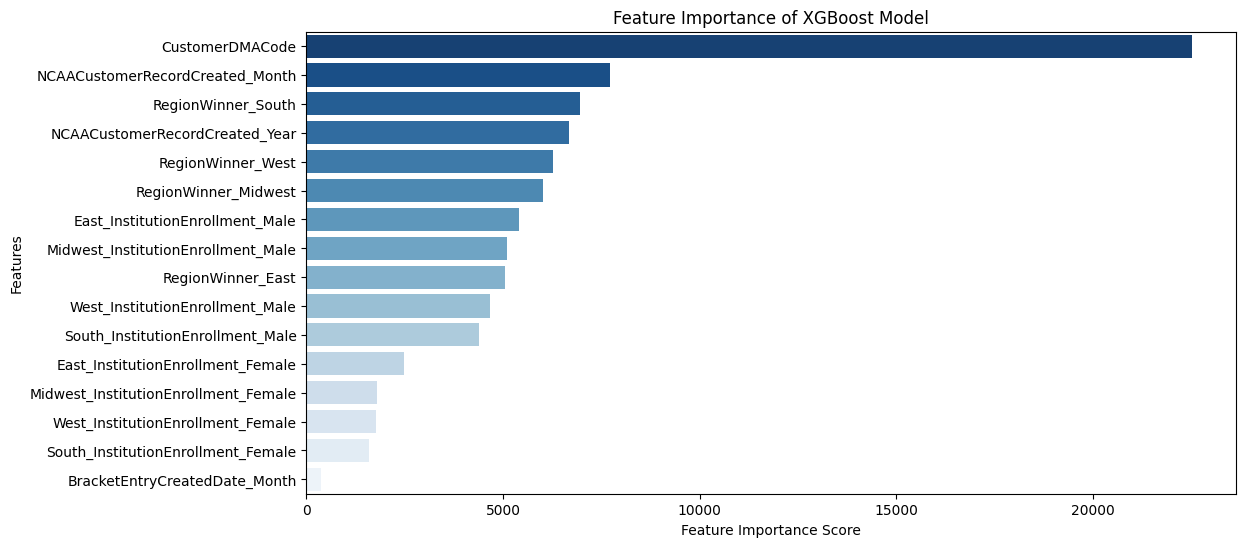

🔹 Feature Importance Results:
                                 Feature  Importance
0                        CustomerDMACode     22529.0
6        NCAACustomerRecordCreated_Month      7726.0
3                     RegionWinner_South      6970.0
5         NCAACustomerRecordCreated_Year      6691.0
2                      RegionWinner_West      6276.0
4                   RegionWinner_Midwest      6019.0
8        East_InstitutionEnrollment_Male      5406.0
14    Midwest_InstitutionEnrollment_Male      5090.0
1                      RegionWinner_East      5058.0
10       West_InstitutionEnrollment_Male      4666.0
12      South_InstitutionEnrollment_Male      4400.0
9      East_InstitutionEnrollment_Female      2470.0
15  Midwest_InstitutionEnrollment_Female      1801.0
11     West_InstitutionEnrollment_Female      1775.0
13    South_InstitutionEnrollment_Female      1591.0
7          BracketEntryCreatedDate_Month       369.0


In [44]:
feature_importance1 = model_nc.get_booster().get_score(importance_type="weight")
                                                       
importance_df = pd.DataFrame({"Feature": feature_importance1.keys(), "Importance": feature_importance1.values()})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_88326/1908786764.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df2, palette="Blues_r")


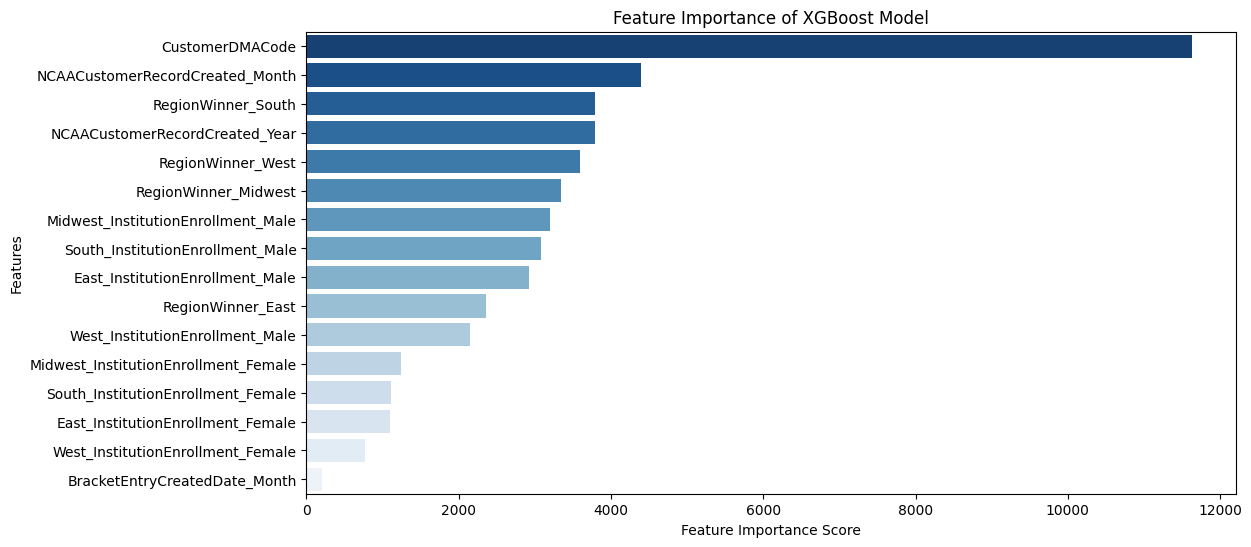

🔹 Feature Importance Results:
                                 Feature  Importance
0                        CustomerDMACode     11633.0
6        NCAACustomerRecordCreated_Month      4400.0
3                     RegionWinner_South      3785.0
5         NCAACustomerRecordCreated_Year      3785.0
2                      RegionWinner_West      3588.0
4                   RegionWinner_Midwest      3343.0
14    Midwest_InstitutionEnrollment_Male      3193.0
12      South_InstitutionEnrollment_Male      3084.0
8        East_InstitutionEnrollment_Male      2918.0
1                      RegionWinner_East      2362.0
10       West_InstitutionEnrollment_Male      2154.0
15  Midwest_InstitutionEnrollment_Female      1240.0
13    South_InstitutionEnrollment_Female      1116.0
9      East_InstitutionEnrollment_Female      1101.0
11     West_InstitutionEnrollment_Female       772.0
7          BracketEntryCreatedDate_Month       200.0


In [46]:
feature_importance2 = model_semi_ew.get_booster().get_score(importance_type="weight")
importance_df2 = pd.DataFrame({"Feature": feature_importance2.keys(), "Importance": feature_importance2.values()})
importance_df2 = importance_df2.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df2, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df2)

/var/folders/4z/mczsf4vs4wsgt6fj97fl9lxw0000gn/T/ipykernel_88326/4285722655.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df3, palette="Blues_r")


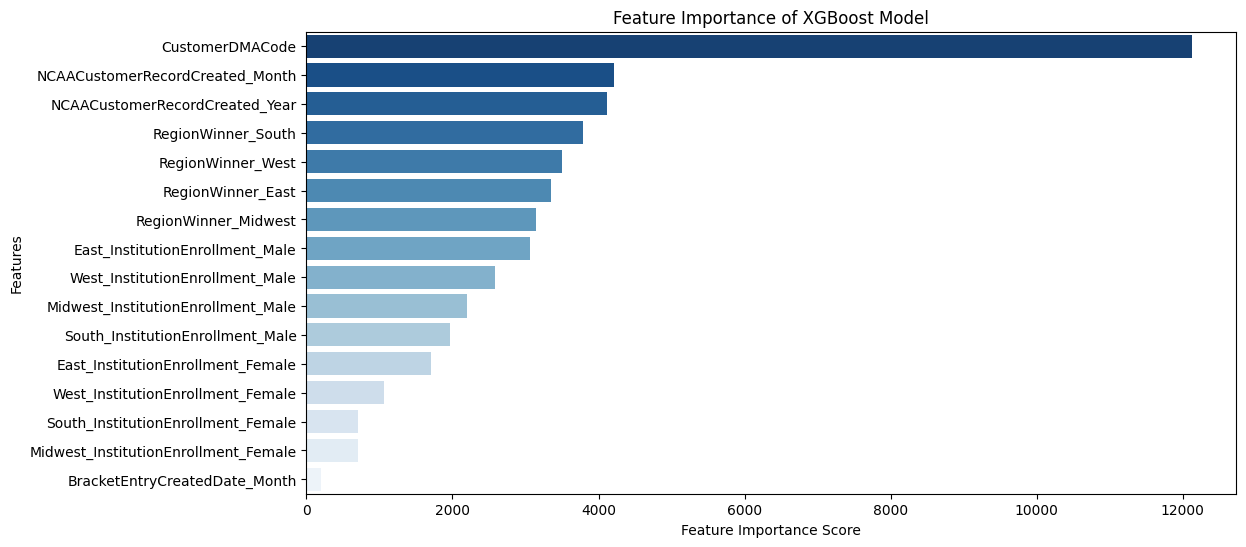

🔹 Feature Importance Results:
                                 Feature  Importance
0                        CustomerDMACode     12129.0
6        NCAACustomerRecordCreated_Month      4217.0
5         NCAACustomerRecordCreated_Year      4117.0
3                     RegionWinner_South      3782.0
2                      RegionWinner_West      3505.0
1                      RegionWinner_East      3346.0
4                   RegionWinner_Midwest      3145.0
8        East_InstitutionEnrollment_Male      3068.0
10       West_InstitutionEnrollment_Male      2580.0
14    Midwest_InstitutionEnrollment_Male      2196.0
12      South_InstitutionEnrollment_Male      1965.0
9      East_InstitutionEnrollment_Female      1707.0
11     West_InstitutionEnrollment_Female      1063.0
13    South_InstitutionEnrollment_Female       713.0
15  Midwest_InstitutionEnrollment_Female       702.0
7          BracketEntryCreatedDate_Month       204.0


In [48]:
feature_importance3 = model_semi_sm.get_booster().get_score(importance_type="weight")
importance_df3 = pd.DataFrame({"Feature": feature_importance3.keys(), "Importance": feature_importance3.values()})
importance_df3 = importance_df3.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=importance_df3, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost Model")
plt.show()

print("🔹 Feature Importance Results:")
print(importance_df3)